## Описание проекта " Прогнозирование заказов такси"

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## 1. Подготовка

### 1.1 Изучение данных

импорты

In [1]:
import time
import warnings

import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import(
    train_test_split,
    TimeSeriesSplit,
    RandomizedSearchCV
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor

warnings.filterwarnings('ignore')
pd.set_option("display.float_format", lambda x: "%.2f" % x)

RS = 17

чтение файла

In [2]:
try:
    df = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col=[0])
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', parse_dates=[0], index_col=[0])

установим индекс таблицы равным столбцу datetime

In [3]:
print('-'*45)
if df.index.is_monotonic == True:
    print('Данные расположены в хронологическом порядке')
else:
    print('Данные расположены не в хронологическом порядке, примените метод sort_index()') 
    
print('-'*45)
display(df.info())
print('-'*40)
display(df)

---------------------------------------------
Данные расположены в хронологическом порядке
---------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

----------------------------------------


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


### 1.2 Ресемлирование

после вывода таблицы видно, что временные рамки расположены в хронологическом порядке, проведем ресемплирование по часам согласно тз

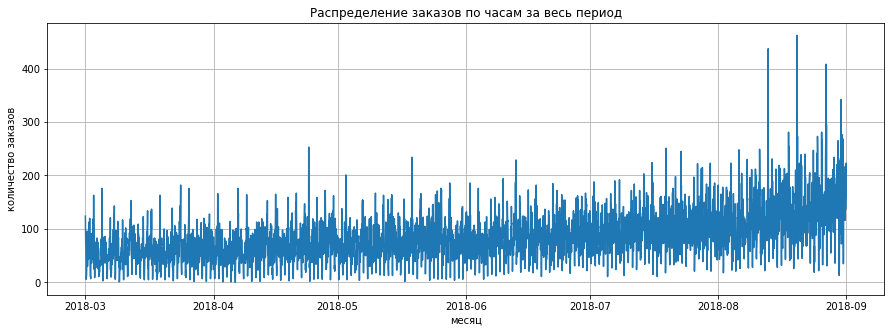

In [4]:
df = df.resample('1H').sum()

plt.figure(figsize=(15,5))
plt.plot(df['num_orders'])
plt.title(f'Распределение заказов по часам за весь период')
plt.xlabel('месяц')
plt.ylabel('количество заказов')
plt.grid()

### 1.3 Вывод

**Вывод по пункту:**

- данные загружены, подготовлены к анализу;
- проведено ресемплирование целевого признака по часам.

Данные готовы к анализу.

## 2. Анализ

### 2.1 Декомпозиция и визуализация

проведем декомпозицию ряда: вглянем на тренд, сезонность, шум

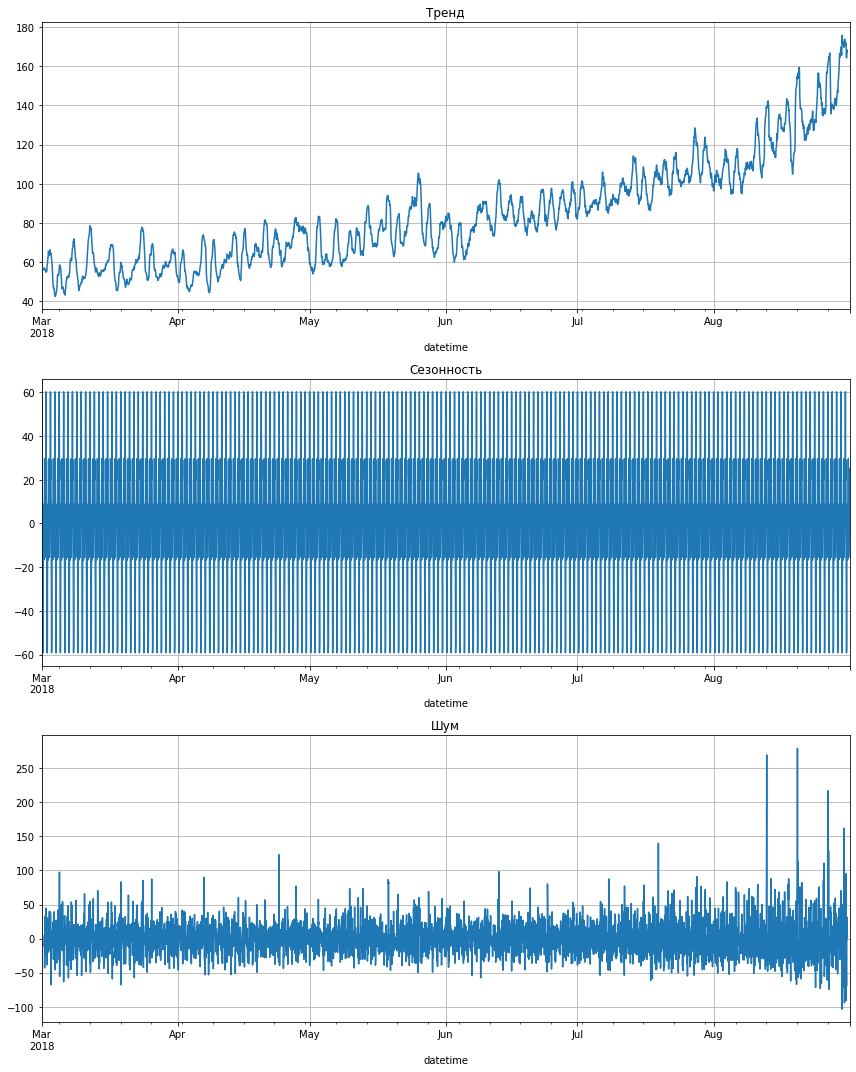

In [5]:
decomposed = seasonal_decompose(df)

plt.figure(figsize=(12, 15))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca(), grid=True)
plt.title('Тренд')
plt.subplot(312)

decomposed.seasonal.plot(ax=plt.gca(), grid=True)
plt.title('Сезонность')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca(), grid=True)
plt.title('Шум')
plt.tight_layout()

посмотрим сезонность нескольких дней в начале июля

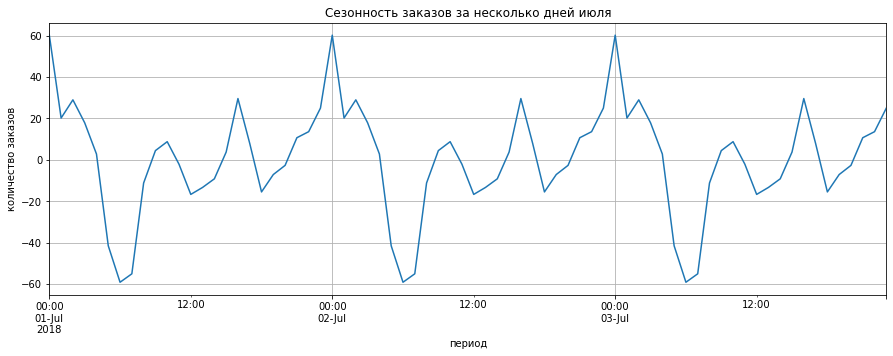

In [6]:
def decomposed_seasonal_period(start_period, end_period, title_period):
    
    plt.figure(figsize=(15,5))
    decomposed.seasonal[start_period:end_period].plot()
    plt.title(f'Сезонность заказов за {title_period}')
    plt.xlabel('период')
    plt.ylabel('количество заказов')
    plt.grid()
    
decomposed_seasonal_period('2018-07-01','2018-07-03', 'несколько дней июля')

присутствует суточная сезонность, проверим недельную сезонность

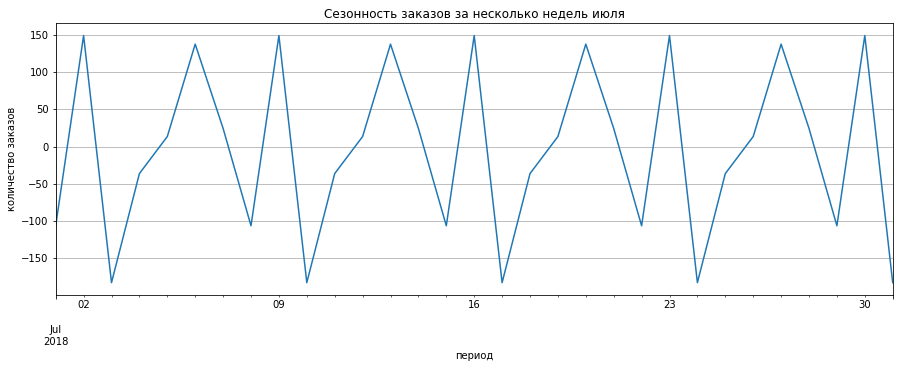

In [7]:
df_day = df.copy().resample('1D').sum()
decomposed = seasonal_decompose(df_day)
decomposed_seasonal_period('2018-07','2018-07', 'несколько недель июля')

присутствует недельная сезонность, как видно на графике, количество заказов имеет нормальное распределение в течение каждой недели и всплеск заказов на каждых выходных. проверять месячную сезонность нет смысла, т.к. весь период составляет полгода - данных мало, нужен период минимум в год

### 2.2 Вывод

Вывод по графикам:

- согласно тренду, количество заказов такси растет с каждым месяцем за последние полгода, особенно большой спрос в конце лета - период отпусков;
- согласно сезонности, в течение дня наибольший спрос такси в аэропортах наблюдается в районах 10 утра, 5 часов вечера и ночью. это связано с количеством сотрудников аэропорта, прибывающих рано утром на работу и уезжающих с работы вечером, а также пассажиропоток: в утренние и дневные часы регулярные популярные рейсы, ночью преимущественно чартерные, летающие в курортные рейсы;
- согласно шуму, в конце лета ситуация с заказами становится непредсказуемой в связи с резкими перепадами количества заказов в сторону увеличения в соотвествии с увеличением значения тренда.

Изучив графики, за количество лагов возьмем значения 24 и 168, т.к. наблюдается разница заказов в течения дня и недели, за скользящее среднее возьмем 24, т.е. среднее за сутки.

## 3. Обучение моделей

### 3.1 Подготовка к обучению

Будем перебирать 2 возможных сценария с количеством лагов, объявим 2 функции: 

- первая - **make_features** - будет создавать новые признаки, лаги, скользящее среднее, делить данные на трейн и тест, в каждом из которых делить данные на признаки и таргеты, на выходе будем получать преобразованные данные и набор отмасштабированных признаков и таргетов для для обучения моделей для каждого значения лагов;

- вторая - **make_cv_time_series** - будет выполнять кросс-валидацию для разных моделей с перебором параметров для улучшения качества предсказания метрики и выводом метрик.

In [8]:
def make_features(data, max_lag, rolling_mean_size):

    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek

    for lag in range(1, max_lag + 1):
            data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    data = data.dropna()
    
    train, test = train_test_split(data, shuffle=False, test_size=.1)

    X_train, y_train = train.drop('num_orders', axis=1), train['num_orders']
    X_test, y_test = test.drop('num_orders', axis=1), test['num_orders']
    
    print(f'Данные при количестве лагов = {max_lag}')
    print('-'*33)
    print(f'размер трейна {X_train.shape}, размер таргета на трейне {y_train.shape}')
    print(f'размер трейна {X_test.shape},  размер таргета на трейне {y_test.shape}') 
    print('-'*60)
    
    return X_train, y_train, X_test, y_test
    
X_train_24, y_train_24, X_test_24, y_test_24 = make_features(df, 24, 24)
X_train_168, y_train_168, X_test_168, y_test_168 = make_features(df, 168, 24)

Данные при количестве лагов = 24
---------------------------------
размер трейна (3952, 27), размер таргета на трейне (3952,)
размер трейна (440, 27),  размер таргета на трейне (440,)
------------------------------------------------------------
Данные при количестве лагов = 168
---------------------------------
размер трейна (3823, 171), размер таргета на трейне (3823,)
размер трейна (425, 171),  размер таргета на трейне (425,)
------------------------------------------------------------


In [9]:
def regressor_cv(model, params, X_train_set, y_train_set):
    
    regressor = RandomizedSearchCV(
         model, 
         params, 
         cv = TimeSeriesSplit(n_splits=5),
         scoring='neg_root_mean_squared_error',
         n_jobs=-1,
         verbose=10
    )
    
    regressor.fit(X_train_set, y_train_set)
    
    rmse_cv = -regressor.best_score_.round(4)
    best_params = regressor.best_params_
    best_model = regressor.best_estimator_
    
    return rmse_cv, best_params, best_model

### 3.2 Обучение

в целях экономии времени работы моделей и ресурсов платформы произведен перебор параметров и указаны лучшие

**Random Forest 24 lags** 

In [10]:
%%time
pipe_rf = Pipeline([
    ('ss',StandardScaler()),
    ('rf',RandomForestRegressor(random_state=RS))
])
params_rf = {
    'rf__max_depth':[25],
    'rf__n_estimators':[500]
}
RF_24lags_rmse_cv, RF_24lags_best_params, RF_24lags_best_model = regressor_cv(
    pipe_rf,
    params_rf,
    X_train_24, 
    y_train_24
)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
CPU times: total: 52 s
Wall time: 1min 49s


**Random Forest 168 lags** 

In [11]:
%%time
params_rf = {
    'rf__max_depth':[50],
    'rf__n_estimators':[500]
}
RF_168lags_rmse_cv, RF_168lags_best_params, RF_168lags_best_model = regressor_cv(
    pipe_rf,
    params_rf,
    X_train_168, 
    y_train_168
)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
CPU times: total: 4min 57s
Wall time: 9min 55s


**Linear Regression 24 lags** 

In [12]:
%%time
pipe_lr = Pipeline([
    ('ss',StandardScaler()),
    ('lr',LinearRegression())
])
LR_24lags_rmse_cv, LR_24lags_best_params, LR_24lags_best_model = regressor_cv(
    pipe_lr,
    {},
    X_train_24, 
    y_train_24
)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
CPU times: total: 203 ms
Wall time: 6.41 s


**Linear Regression 168 lags** 

In [13]:
%%time
LR_168lags_rmse_cv, LR_168lags_best_params, LR_168lags_best_model = regressor_cv(
    pipe_lr,
    {},
    X_train_168, 
    y_train_168
)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
CPU times: total: 484 ms
Wall time: 2.99 s


**LightGBM Regressor 24 lags** 

In [14]:
%%time
params_lgbm = {
    'lgbm__iterations':[100],
    'lgbm__max_depth': [5],
    'lgbm__learning_rate':[0.01]
}
LGBM_24lags_rmse_cv, LGBM_24lags_best_params, LGBM_24lags_best_model = regressor_cv(
    LGBMRegressor(random_state=RS),
    params_lgbm,
    X_train_24, 
    y_train_24
)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LightGBM] [Warning] Unknown parameter: lgbm__max_depth
[LightGBM] [Warning] Unknown parameter: lgbm__learning_rate
[LightGBM] [Warning] Unknown parameter: lgbm__iterations
CPU times: total: 1.91 s
Wall time: 3.77 s


**LightGBM Regressor 168 lags** 

In [15]:
%%time
params_lgbm = {
    'lgbm__iterations':[100],
    'lgbm__max_depth': [5],
    'lgbm__learning_rate':[0.01]
}
LGBM_168lags_rmse_cv, LGBM_168lags_best_params, LGBM_168lags_best_model = regressor_cv(
    LGBMRegressor(random_state=RS),
    params_lgbm,
    X_train_168, 
    y_train_168
)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
CPU times: total: 5.36 s
Wall time: 5.49 s


### 3.3 Вывод

выведем результаты в таблицу

In [16]:
pd.DataFrame({
    'RandomForest':[RF_24lags_rmse_cv, 
                    RF_168lags_rmse_cv],
    'LinearRegression':[LR_24lags_rmse_cv,
                        LR_168lags_rmse_cv],
    'LightGBM':[LGBM_24lags_rmse_cv, 
                LGBM_168lags_rmse_cv]
    },
    index=['RMSE valid 24 lags',
          'RMSE valid 168 lags']
)

,RandomForest,LinearRegression,LightGBM
RMSE valid 24 lags,25.09,27.14,25.12
RMSE valid 168 lags,22.95,22.69,23.39


**Вывод по пункту:** 

- по итогу обучения моделей лучшее значение метрики на кросс-валидации показала линейная регрессия с 168 лагами. Далее проверим ее на тестовой выборке. 

## 4. Тестирование

выведем итоговые показатели модели с лучшим значением метрики и визуализацию

,Linear Regression 168 lags
rmse valid,22.69
rmse test,34.26


----------------------------------------------------------------------------------------------------------------------------------------------------------------


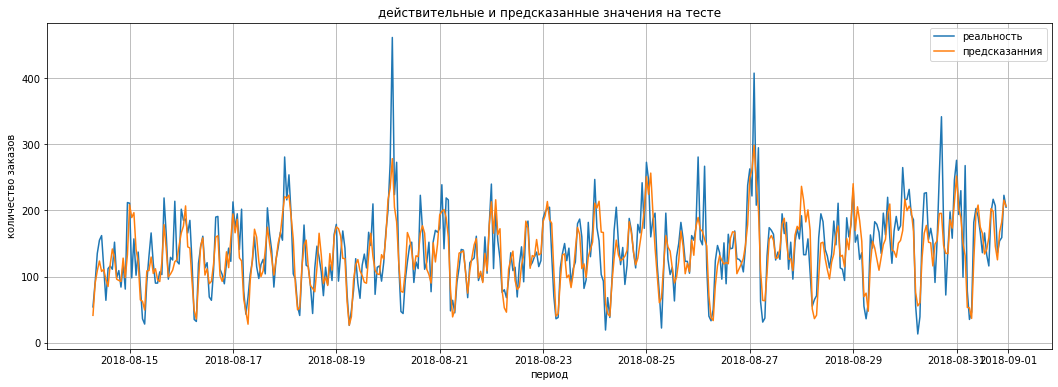

In [17]:
LR_168lags_rmse_test = round(mean_squared_error(
    y_test_168,LR_168lags_best_model.predict(X_test_168),squared=False),2
)

display(pd.DataFrame({
    'Linear Regression 168 lags':
                 [LR_168lags_rmse_cv,
                  LR_168lags_rmse_test]
},
    index=['rmse valid',
           'rmse test']
        )
)

print('-'*160)
plt.subplots(figsize=(18,6))
plt.plot(y_test_168.index, y_test_168, label="реальность")
plt.plot(y_test_168.index, LR_168lags_best_model.predict(X_test_168), label="предсказанния")
plt.title("действительные и предсказанные значения на тесте")
plt.xlabel("период")
plt.ylabel("количество заказов")
plt.legend()
plt.grid()

**Вывод по тестированию лучшей модели:**

- лучшая модель показала отличный результат на тестовой выборке, учитывая разницу предсказаний на кросс-валидации и тестовой выборки;
- на графике видно, что лучшая модель большей частью предсказывает целевой признак правильно; в большинстве случаев модель ошибается в пиковые нагрузки, в остальных случаях в краткосрочных всплесках заказов. 

## 5. Вывод по проекту

Мы работаем с заказом компании "Чётенькое такси". Компания предоставила нам исторические даные за последние полгода о заказах такси в аэропортах, чтобы мы могли на их основе предсказать требуемое количество машин такси на ближайший час. Нашей задачей является разработка и отладка модели предсказания со значением метрики RMSE не более 48, т.е. итоговая модель должна ошибаться не более чем на 48 заказов в час. 

В течение работы над проектом были проработаны следующие этапы:

- изучены и предобработаны данные, представляющие собой временной ряд;
- проведено ресемплирование временного ряда но часам и дням недели;
- на основе пункта выше проведены визуализация данных и их анализ, выявлены часовая и недельная сезонность;
- на основе проведенного анализа было предложено 2 варианта создания признаков для обучения моделей;
- была создана функция, которая создает признаки на основе обоих вариантов выявленной сезонности в данных, преобразует датасет, производит его разделение на выборки;
- проведена кросс-валидация данных на разных моделях с перебором параметров, получены значения метрик для каждого варианта модели;
- на основе полученных значений метрик моделей выбрана модель с лучшим показателем и осуществлена ее проверка на тестовых данных;
- результаты на тестовых данных выведены в таблицу и визуализированы, подведен итоговый вывод.

По результатам работы проекта можно сказать, что с работой над временными рядами все модели показали отличный результат с минимальной разницой между собой по изучаемой метрике. Это говорит о том, что была проведена корректная обработка данных и обучение моделей. Для решения поставленной задачи нам подходят все модели, но по условию тз требуется только одна - линейная регрессия, т.к. она показала лучшее значение метрики RMSE.

Для дальнейшего использования выбранной модели требуется ее дальнейшая доработка и оптимизация для работы на платформе заказчика. 